## Reflection Agent - Planner and Self-Critique Agents
### Web Research with Iterative Self-Improvement

Learning Objectives:
- Build a research agent with web search
- Implement critique agent for quality control
- Use reflection loop with max iterations

#### Real-World Use Cases:
1. **Content Research**: Gather and refine information
2. **Report Generation**: Iteratively improve quality
3. **Fact Checking**: Verify and enhance accuracy
4. **Competitive Analysis**: Research and critique findings

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from typing_extensions import TypedDict, Annotated
import operator
from langgraph.graph import StateGraph, START, END

from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

# Configuration
BASE_URL = "http://localhost:11434"
# MODEL_NAME = "qwen3"
# MODEL_NAME = "gpt-oss"
MODEL_NAME = "qwen3:14b"

llm = ChatOllama(model=MODEL_NAME, base_url=BASE_URL)

### Web Search Tool

In [3]:
# DuckDuckGo search integration
from ddgs import DDGS

@tool
def web_search(query: str, num_results: int = 5) -> str:
    """Search the web using DuckDuckGo.
    
    Args:
        query: Search query string
        num_results: Number of results to return (default: 5)
    
    Returns:
        Formatted search results with titles, descriptions, and URLs
    """
    
    try:
        results = list(DDGS().text(query = query,
                                   max_results=num_results,
                                   region="us-en"))
        
        if not results:
            return f"No results found for '{query}'"
        
        formatted_results = [f"Search Results for '{query}':\n"]
        for i, result in enumerate(results, 1):
            title = result.get('title', 'No title')
            body = result.get('body', 'No description available')
            href = result.get('href', '')
            formatted_results.append(f"{i}. **{title}**\n   {body}\n   {href}")
        
        return "\n\n".join(formatted_results)
    
    except Exception as e:
        return f"Search error: {str(e)}"

In [4]:
# test
web_search.invoke({'query': 'LangGraph tutorials', 'num_results': 3})

"Search Results for 'LangGraph tutorials':\n\n\n1. **LangGraph - LangChain**\n   LangGraph's flexible framework supports diverse control flows – single agent, multi-agent, hierarchical, sequential – and robustly handles realistic, complex scenarios. Ensure reliability …\n   https://www.langchain.com/langgraph\n\n2. **GitHub - langchain-ai/ langgraph : Build resilient language agents …**\n   Build resilient language agents as graphs. Contribute to langchain-ai/langgraph development by creating an account on GitHub.\n   https://github.com/langchain-ai/langgraph\n\n3. **How to Use LangChain and LangGraph : A Beginner’s Guide to AI …**\n   1 day ago · LangGraph is an extension of LangChain that introduces a graph-based approach to AI workflows. Instead of chaining steps in one direction, LangGraph lets you define nodes and …\n   https://www.freecodecamp.org/news/how-to-use-langchain-and-langgraph-a-beginners-guide-to-ai-workflows/"

### Agent State

In [5]:
# Create Agent State
class AgentState(TypedDict):
    messages: Annotated[list, operator.add]
    research: str  # stores research output
    critique: str  # stores critique feedback
    iterations: int  # track iterations

### Researcher Node

In [6]:
def researcher_node(state: AgentState):

    llm_with_tools = llm.bind_tools([web_search])

    critique = state.get('critique', '')
    iteration = state.get('iterations', 0)

    critique_context = ""
    if critique:
        critique_context = f"""
                Previous Critique: {critique}
                Address the missing points with new search queries.
                """

    system_prompt = SystemMessage(f"""
        You are a research agent with web search capabilities.
        {critique_context}
        INSTRUCTIONS:
        1. **MUST use web_search tool** first to gather information
        2. Provide comprehensive research based on search results

        Always call **web_search** before responding.
    """)

    messages = [system_prompt] + state['messages']

    response = llm_with_tools.invoke(messages)

    if hasattr(response, 'tool_calls') and response.tool_calls:
        for tc in response.tool_calls:
            print(f"[RESEARCHER] calling Tool {tc.get('name', '?')} with args {tc.get('args', '?')}")
    else:
        print(f"[RESEARCHER] Iteration {iteration + 1} - Research complete")

    return {'messages': [response]}

### Critique Node

In [7]:
def critique_node(state: AgentState):
    
    messages = state['messages']
    iteration = state.get('iterations', 0)
    
    # extract research from messages
    research_content = ""
    for msg in reversed(messages):
        if hasattr(msg, 'content') and msg.content:
            research_content = msg.content
            break
    
    system_prompt = SystemMessage("""
        You are a critique agent. Evaluate if research is good enough.
        
        Check:
        1. Does it answer the main question?
        2. Is there reasonable detail?
        
        Response Format:
        DECISION: APPROVE or REVISE
        
        Be lenient. APPROVE if research is decent enough.
        Only REVISE if critical information is completely missing.
    """)
    
    critique_prompt = HumanMessage(f"""
        Evaluate this research:
        
        {research_content}
    """)
    
    response = llm.invoke([system_prompt, critique_prompt])
    
    print(f"[CRITIQUE] Iteration {iteration + 1} - Evaluation complete")
    
    return {
        'critique': response.content,
        'research': research_content,
        'iterations': iteration + 1
    }

### Routing Logic

In [8]:
# Routing from researcher
def should_continue(state: AgentState):
    last = state['messages'][-1]
    
    if hasattr(last, 'tool_calls') and last.tool_calls:
        return "tools"
    else:
        return "critique"

In [9]:
# Routing from critique
MAX_ITERATIONS = 10

def check_approval(state: AgentState):
    
    critique = state.get('critique', '')
    iterations = state.get('iterations', 0)
    
    # max iterations reached
    if iterations >= MAX_ITERATIONS:
        print(f"[SYSTEM] Max iterations ({MAX_ITERATIONS}) reached. Stopping.")
        return END
    
    # check if approved
    if 'APPROVE' in critique.upper():
        print(f"[SYSTEM] Research approved after {iterations} iteration(s)")
        return END
    else:
        print(f"[SYSTEM] Revision needed. Continuing iteration {iterations + 1}")
        return "researcher"

### Build Graph

In [10]:
# =============================================================================
# Graph
# =============================================================================
def create_agent():

    builder = StateGraph(AgentState)

    builder.add_node("researcher", researcher_node)
    builder.add_node("tools", ToolNode([web_search]))
    builder.add_node("critique", critique_node)

    builder.add_edge(START, "researcher")
    builder.add_conditional_edges("researcher", should_continue, ["tools", "critique"])
    builder.add_edge("tools", "researcher")
    builder.add_conditional_edges("critique", check_approval, ["researcher", END])

    graph = builder.compile()

    return graph

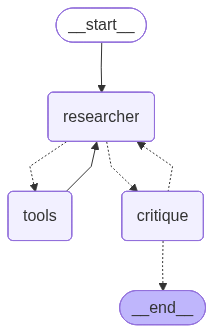

In [11]:
agent = create_agent()
agent

### Run Agent

In [12]:
query = "What are the latest developments in LangGraph for building AI agents?"

result = agent.invoke({
    'messages': [HumanMessage(query)],
    'research': '',
    'critique': '',
    'iterations': 0
})

[RESEARCHER] calling Tool web_search with args {'num_results': 5, 'query': 'latest developments in LangGraph for AI agents 2023'}
[RESEARCHER] Iteration 1 - Research complete
[CRITIQUE] Iteration 1 - Evaluation complete
[SYSTEM] Research approved after 1 iteration(s)


In [13]:
# Final research output
print("\n" + "="*80)
print("FINAL RESEARCH OUTPUT")
print("="*80 + "\n")
print(result['research'])


FINAL RESEARCH OUTPUT

The latest developments in **LangGraph** (as of 2023/2024) focus on enhancing flexibility, scalability, and integration for building AI agents. Here's a synthesis of the key advancements based on recent resources:

---

### 1. **Graph-Based Architecture for Autonomous Agents**
   - **Foundational Principles**: LangGraph emphasizes a **graph-based architecture** to model agent workflows, enabling complex decision-making and task orchestration. This approach allows agents to dynamically route tasks, manage state, and handle multi-step reasoning.
   - **Customizable Runtime**: Developers can now define personalized action plans and decision-making logic, offering greater control over agent behavior compared to traditional frameworks.

---

### 2. **Integration with LangChain Ecosystem**
   - **Seamless Tooling**: LangGraph integrates with **LangChain** (a platform for building reliable agents), providing tools for:
     - **Long-term memory** (e.g., persistent stor

In [14]:
# result

In [15]:
query = "Do research on Nvidia stock performance and recent news."

result = agent.invoke({
    'messages': [HumanMessage(query)],
    'research': '',
    'critique': '',
    'iterations': 0
})

[RESEARCHER] calling Tool web_search with args {'num_results': 10, 'query': 'Nvidia stock performance and recent news'}
[RESEARCHER] Iteration 1 - Research complete
[CRITIQUE] Iteration 1 - Evaluation complete
[SYSTEM] Research approved after 1 iteration(s)


In [16]:
print(result['research'])

Nvidia (NVDA) has demonstrated strong stock performance, with recent data indicating a **49.6% year-to-date increase** as of early 2024, driven by its leadership in AI innovation and semiconductor technology. Here's a synthesis of key insights from recent research:

### **Stock Performance**
- **YTD Growth**: Nvidia's stock has surged over 49.6% year-to-date, reflecting robust investor confidence in its AI and semiconductor business. Some reports note a **51% gain through the first 10 months of 2025**, though this may be a typographical error given the current year.
- **Market Momentum**: The stock has maintained upward momentum, with analysts attributing its growth to demand for GPUs in AI, data centers, and gaming, as well as strategic product launches (e.g., Hopper architecture, Omniverse platform).

### **Recent News & Drivers**
1. **AI and Semiconductor Innovation**:
   - Nvidia's advancements in AI chips (e.g., Blackwell series) and AI software (e.g., CUDA, Omniverse) have solidi

In [17]:
print(result['critique'])

DECISION: APPROVE

The research provides a comprehensive overview of Nvidia's stock performance, key drivers (AI innovation, semiconductor demand), financial highlights, competitive positioning, and risks. It answers the main question about Nvidia's stock surge and includes sufficient detail. Minor issues (e.g., potential typo in "2025" timeline, unrelated mention of Beyond Meat) are non-critical and do not detract from the overall quality or clarity of the analysis.
